In [1]:
%matplotlib widget

In [2]:
import copy
import marvin
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import utils
from astropy.wcs import WCS
from astropy.convolution import convolve, Gaussian2DKernel
from reproject import reproject_interp, reproject_exact

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [3]:
!pwd

/home/idies/workspace/Storage/prajwel/persistent/manga_analysis


In [4]:
target_cube = "10510-12704"
# https://dr17.sdss.org/marvin/galaxy/10510-12704/

In [5]:
my_cube = marvin.tools.Cube(target_cube)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
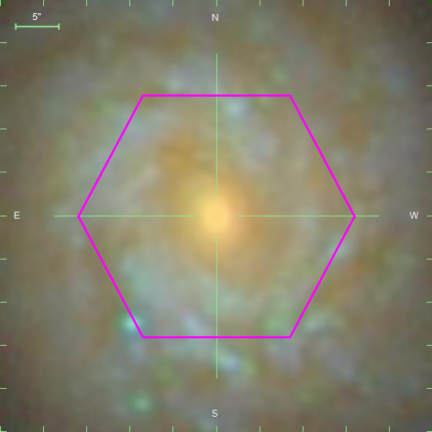

In [6]:
image = my_cube.getImage()
image.plot()

image.save('hexagon_overlay.png')

In [7]:
polygon_region = '''# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
polygon{} # color=red width=1 dash=0'''

def get_polygon(target_cube):
    my_cube = marvin.tools.Cube(target_cube)
    image = my_cube.getImage()
    hexagon_array = image.bundle.hexagon.flatten()
    polygon = polygon_region.format(tuple(hexagon_array))
    # print(polygon)
    with open(target_cube + '_hexagon.reg', "w") as text_file:
        text_file.write(polygon)


In [8]:
get_polygon(target_cube)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
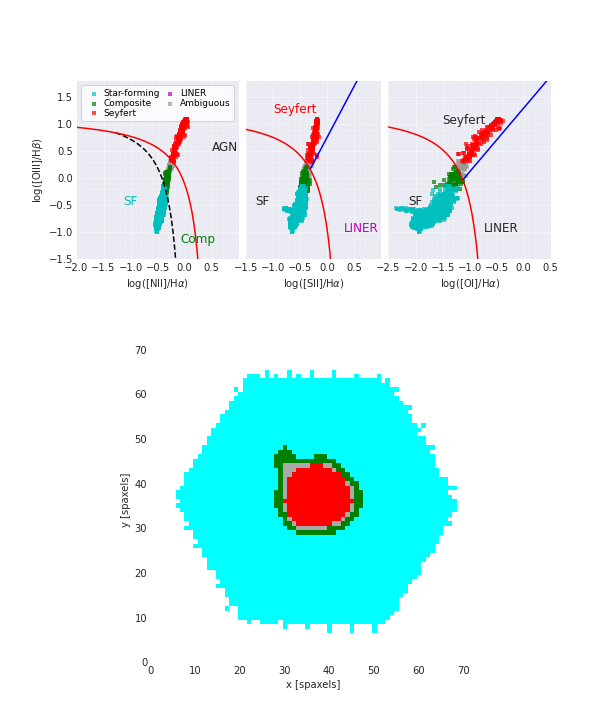

In [8]:
maps = marvin.tools.Maps(target_cube)

# make a standard 3-plot BPT and retrieve the classifications
masks, fig, axes = maps.get_bpt(snr=3)

# save the plot
fig.savefig('bpt.png', dpi = 300)

In [9]:
bpt_array = np.ones(masks["agn"]["global"].shape)
bpt_array[masks["agn"]["global"]] = 4
bpt_array[masks["ambiguous"]["global"]] = 3
bpt_array[masks["comp"]["global"]] = 2
bpt_array[masks["sf"]["global"]] = 1
bpt_array[masks["invalid"]["global"]] = 0
hdu = fits.PrimaryHDU(data = bpt_array)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('bpt.fits', overwrite = True)

In [10]:
np.unique(bpt_array, return_counts = True)

(array([0., 1., 2., 3., 4.]), array([2798, 2384,   88,   40,  166]))

In [13]:
oiii_hb = maps.emline_gflux_oiii_5008 / maps.emline_gflux_hb_4862
oiii_hb.value[oiii_hb.pixmask.mask != 0] = np.nan
hdu = fits.PrimaryHDU(data = oiii_hb.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('oiii_hb.fits', overwrite = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
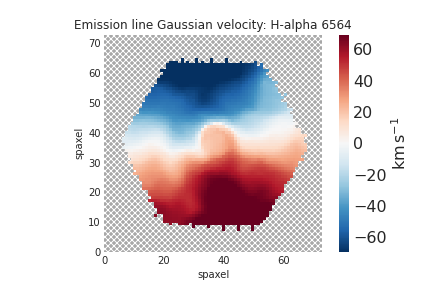

In [58]:
gas_vfield = maps.emline_gvel_ha_6564
fig, ax = gas_vfield.plot()
gas_vfield.value[gas_vfield.pixmask.mask != 0] = np.nan
hdu = fits.PrimaryHDU(data = gas_vfield.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('gas_vfield.fits', overwrite = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
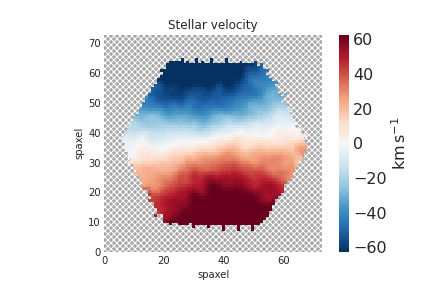

In [59]:
stellar_vfield = maps.stellar_vel
fig, ax = stellar_vfield.plot()
stellar_vfield.value[stellar_vfield.pixmask.mask != 0] = np.nan
hdu = fits.PrimaryHDU(data = stellar_vfield.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('stellar_vfield.fits', overwrite = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
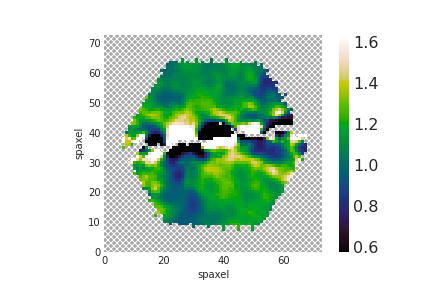

In [22]:
residual = gas_vfield / stellar_vfield
residual.plot()
hdu = fits.PrimaryHDU(data = residual.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('residual_gas_by_stellar.fits', overwrite = True)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='spaxel', ylabel='spaxel'>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
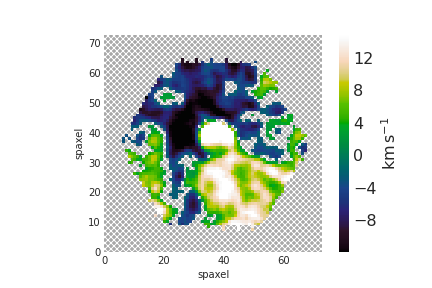

In [23]:
vel_diff = gas_vfield - stellar_vfield
vel_diff.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
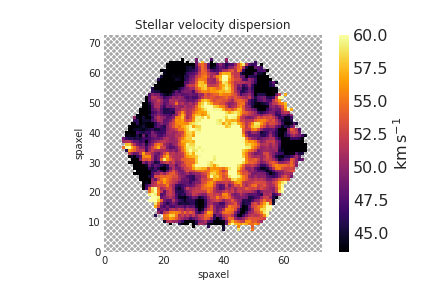

In [60]:
stellar_disp_raw = maps.stellar_sigma
stellar_disp_stars_corr = stellar_disp_raw.inst_sigma_correction()
stellar_disp_stars_corr.plot()
stellar_disp_stars_corr.value[stellar_disp_stars_corr.pixmask.mask != 0] = np.nan
# stellar_disp_stars_corr.value[stellar_disp_stars_corr.value == 0] = np.nan
hdu = fits.PrimaryHDU(data = stellar_disp_stars_corr.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('stellar_disp_stars_corr.fits', overwrite = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
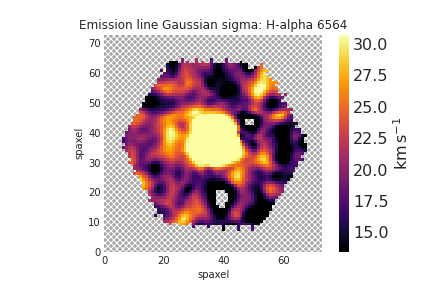

In [31]:
gas_disp_raw = maps.emline_gsigma_ha_6564
gas_disp_stars_corr = gas_disp_raw.inst_sigma_correction()
gas_disp_stars_corr.plot()
gas_disp_stars_corr.value[stellar_disp_stars_corr.pixmask.mask != 0] = np.nan
hdu = fits.PrimaryHDU(data = gas_disp_stars_corr.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('gas_disp_stars_corr.fits', overwrite = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
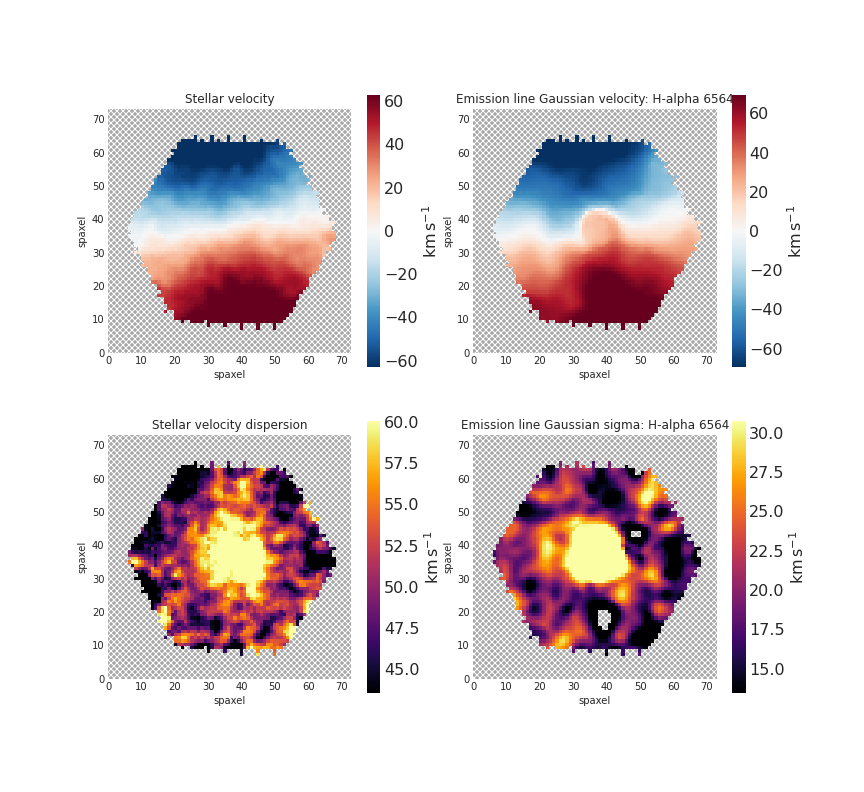

In [14]:
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 11))
    stellar_vfield.plot(fig=fig, ax=axes[0, 0])
    gas_vfield.plot(fig=fig, ax=axes[0, 1])
    stellar_disp_stars_corr.plot(fig=fig, ax=axes[1, 0])
    gas_disp_stars_corr.plot(fig=fig, ax=axes[1, 1])
    
fig.savefig('velocity_and_dispersion.png', dpi = 300)

In [62]:
ha = maps.emline_gflux_ha_6564
hb = maps.emline_gflux_hb_4862
ha_hb = ha / hb

In [63]:
theoretical_ratio = np.ones(masks["agn"]["global"].shape)
theoretical_ratio[masks["agn"]["global"]] = 3.1
theoretical_ratio[~masks["agn"]["global"]] = 2.86
colour_excess = 1.97 * np.log10((ha_hb / theoretical_ratio))
A_v = 4.05 * colour_excess
hdu = fits.PrimaryHDU(data = A_v.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('A_v.fits', overwrite = True)

In [64]:
# colour_excess = 1.97 * np.log10((ha_hb / 2.86))
# A_v = 4.05 * colour_excess
# hdu = fits.PrimaryHDU(data = A_v.value)
# hdu.header.update(maps.wcs.dropaxis(2).to_header())
# hdu.writeto('A_v_just_SF.fits', overwrite = True)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='spaxel', ylabel='spaxel'>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
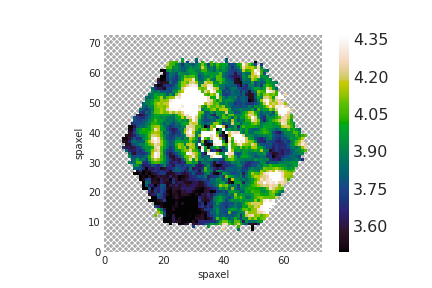

In [65]:
ha_hb.plot()

In [66]:
GALEX_NUV_wavelength = 2315.7 / 1e4 

k_NUV = 2.659 * (-2.156 + \
                  1.509 / GALEX_NUV_wavelength - \
                  0.198 / (GALEX_NUV_wavelength ** 2) + \
                  0.011 / (GALEX_NUV_wavelength ** 3)) + \
                  4.05 
print(k_NUV)

8.204323334258596


In [67]:
A_NUV = k_NUV * colour_excess
hdu = fits.PrimaryHDU(data = A_NUV.value)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('A_NUV.fits', overwrite = True)

In [68]:
flux_ext = 10 ** (0.4 * k_NUV * colour_excess.value) # To multiply
hdu = fits.PrimaryHDU(data = flux_ext)
hdu.header.update(maps.wcs.dropaxis(2).to_header())
hdu.writeto('flux_ext_nuv_factor.fits', overwrite = True)

In [22]:
print(masks.keys())

dict_keys(['sf', 'comp', 'agn', 'seyfert', 'liner', 'invalid', 'ambiguous'])


In [23]:
y, x = np.where(masks["agn"]["global"])
skycoo = utils.pixel_to_skycoord(x, y, maps.wcs)
agn_points = np.array([skycoo.ra.degree, skycoo.dec.degree]).T
np.savetxt("agn_bpt.txt", agn_points)

y, x = np.where(masks["ambiguous"]["global"])
skycoo = utils.pixel_to_skycoord(x, y, maps.wcs)
ambiguous_points = np.array([skycoo.ra.degree, skycoo.dec.degree]).T
np.savetxt("ambiguous_bpt.txt", ambiguous_points)

y, x = np.where(masks["comp"]["global"])
skycoo = utils.pixel_to_skycoord(x, y, maps.wcs)
comp_points = np.array([skycoo.ra.degree, skycoo.dec.degree]).T
np.savetxt("comp_bpt.txt", comp_points)

y, x = np.where(masks["sf"]["global"])
skycoo = utils.pixel_to_skycoord(x, y, maps.wcs)
sf_points = np.array([skycoo.ra.degree, skycoo.dec.degree]).T
np.savetxt("sf_bpt.txt", sf_points)

As per Galex paper (Morrissey 2007), 

* NUV FWHM = 5.3"
* FUV FWHM = 4.2"

Manga pixel scale is 0.5 arcseconds. 

In [24]:
# flux_ext[np.isnan(flux_ext)] = 0
# kernel_stddev = 5.3 * 0.42467 / 0.5
# kernel = Gaussian2DKernel(x_stddev = kernel_stddev)
# smoothed_flux_ext = convolve(flux_ext, kernel)
# hdu = fits.PrimaryHDU(data = smoothed_flux_ext)
# hdu.header.update(maps.wcs.dropaxis(2).to_header())
# hdu.writeto('smoothed_flux_ext_nuv_factor.fits', overwrite = True)

In [25]:
# reference = 'flux_ext_nuv_factor.fits'
# to_align = 'GI6_012039_HRS74_75-nd-int.fits.gz'

# reference_hdu = fits.open(reference)
# to_align_hdu = fits.open(to_align)

# array, footprint = reproject_exact(to_align_hdu, reference_hdu[0].header, parallel = True)

# wcs = WCS(reference_hdu[0].header)
# to_align_hdu[0].header.update(wcs.to_header(relax=True), 'update')
# fits.writeto('aligned_' + to_align, array, to_align_hdu[0].header, overwrite=True)
# fits.writeto('attenuation_corrected_' + to_align, array * smoothed_flux_ext_hdu[0].data, to_align_hdu[0].header, overwrite=True)